In [9]:
import joblib
import base64
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from IPython.display import display, Markdown, Latex, HTML

model_pipeline = joblib.load("../../data/model_pipeline.joblib")
train_path = "../../data/data_test.csv" 
df = pd.read_csv(train_path, sep=",", decimal=".")

# Scheiden van target en input variabelen
target = "Churn"

X = df.drop(columns=[target])
y = df[target]
y_pred = model_pipeline.predict(X)
X.shape, y.shape

((855, 9), (855,))

In [10]:
def latex_cr(cr):
    c0 = cr['0']
    c1 = cr['1']
    macro = cr['macro avg']
    weighted = cr['weighted avg']
    acc = cr['accuracy']

    output = rf"""
$$
\begin{{array}}{{lrrrr}}
\text{{}} & \text{{Precision}} & \text{{Recall}} & \text{{F1-score}} & \text{{Support}} \\\hline
0 & {c0['precision']:.2f} & {c0['recall']:.2f} & {c0['f1-score']:.2f} & {c0['support']:.0f} \\
1 & {c1['precision']:.2f} & {c1['recall']:.2f} & {c1['f1-score']:.2f} & {c1['support']:.0f} \\\hline
\text{{accuracy}} & & & {acc:.2f} & \\
\text{{macro avg}} & {macro['precision']:.2f} & {macro['recall']:.2f} & {macro['f1-score']:.2f} & {macro['support']:.0f} \\
\text{{weighted avg}} & {weighted['precision']:.2f} & {weighted['recall']:.2f} & {weighted['f1-score']:.2f} & {weighted['support']:.0f}
\end{{array}}
$$
"""
    return Latex(output)


print("Accuracy:", accuracy_score(y, y_pred))
print("\nClassification report:\n", classification_report(y, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y, y_pred))
display(latex_cr(classification_report(y, y_pred,  zero_division=True, output_dict=True)))

Accuracy: 0.9122807017543859

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95       734
           1       0.88      0.44      0.59       121

    accuracy                           0.91       855
   macro avg       0.90      0.71      0.77       855
weighted avg       0.91      0.91      0.90       855


Confusion matrix:
 [[727   7]
 [ 68  53]]


<IPython.core.display.Latex object>

In [11]:
def display_executive_model_evaluation(y_true, y_pred, class_names=None):

    # -------------------------
    # Label mapping
    # -------------------------
    unique_labels = sorted(list(set(y_true)))

    if class_names:
        if len(class_names) != len(unique_labels):
            raise ValueError("class_names moet dezelfde lengte hebben als unieke labels.")
        label_map = dict(zip(unique_labels, class_names))
        y_true = [label_map[y] for y in y_true]
        y_pred = [label_map[y] for y in y_pred]
        used_labels = class_names
    else:
        used_labels = [str(l) for l in unique_labels]

    # -------------------------
    # Metrics
    # -------------------------
    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    macro = report.get("macro avg", {})
    weighted = report.get("weighted avg", {})

    class_metrics = []
    for cls in used_labels:
        c = report.get(cls, {"precision":0,"recall":0,"f1-score":0,"support":0})
        class_metrics.append({
            "label": cls,
            "precision": c["precision"],
            "recall": c["recall"],
            "f1": c["f1-score"],
            "support": int(c["support"])
        })

    # -------------------------
    # Hover explanations
    # -------------------------
    hover = {
        "accuracy": "Percentage correcte voorspellingen = juiste voorspellingen / totaal aantal observaties.",
        "macro": "Macro gemiddelde: gelijke weging per klasse, ongeacht grootte.",
        "weighted": "Weighted gemiddelde: gewogen naar aantal observaties per klasse.",
        "precision": "Precision = TP / (TP + FP)",
        "recall": "Recall = TP / (TP + FN)",
        "f1": "F1-score = Harmonic mean van Precision en Recall.",
        "support": "Aantal observaties in deze klasse."
    }

    def info_icon(text):
        return f'<span style="font-size:12px; color:#9CA3AF; cursor:help; margin-left:4px;" title="{text}">ⓘ</span>'

    # -------------------------
    # HTML REPORT
    # -------------------------
    html = f"""
    <div style="
        font-family:'Segoe UI', Arial, sans-serif;
        max-width:1000px;
        padding:30px;
        color:#111827;
        background:#FFFFFF;
        border-radius:8px;
        box-shadow: 0 8px 20px rgba(0,0,0,0.1);  /* Extra premium schaduw */
    ">

        <div style="font-size:28px; font-weight:600; margin-bottom:35px;">
            Model Performance Summary
        </div>

        <div style="display:flex; gap:80px; margin-bottom:45px;">

            <div>
                <div style="font-size:13px; color:#6B7280;">
                    Accuracy {info_icon(hover["accuracy"])}
                </div>
                <div style="font-size:44px; font-weight:600; margin-top:4px;">
                    {acc:.2%}
                </div>
            </div>

            <div>
                <div style="font-size:13px; color:#6B7280;">
                    Macro Average {info_icon(hover["macro"])}
                </div>
                <div style="margin-top:6px; font-size:16px; line-height:1.6;">
                    Precision: <b>{macro.get("precision",0):.2f}</b><br>
                    Recall: <b>{macro.get("recall",0):.2f}</b><br>
                    F1-score: <b>{macro.get("f1-score",0):.2f}</b>
                </div>
            </div>

            <div>
                <div style="font-size:13px; color:#6B7280;">
                    Weighted Average {info_icon(hover["weighted"])}
                </div>
                <div style="margin-top:6px; font-size:16px; line-height:1.6;">
                    Precision: <b>{weighted.get("precision",0):.2f}</b><br>
                    Recall: <b>{weighted.get("recall",0):.2f}</b><br>
                    F1-score: <b>{weighted.get("f1-score",0):.2f}</b>
                </div>
            </div>

        </div>

        <div style="height:1px; background:#E5E7EB; margin-bottom:40px;"></div>

        <div style="font-size:20px; font-weight:600; margin-bottom:20px;">
            Per Class Performance
        </div>

        <table style="width:100%; border-collapse:collapse; font-size:15px;">
            <thead>
                <tr style="text-align:left; border-bottom:2px solid #111827;">
                    <th style="padding:12px 0;">Class</th>
                    <th>Precision {info_icon(hover["precision"])}</th>
                    <th>Recall {info_icon(hover["recall"])}</th>
                    <th>F1-score {info_icon(hover["f1"])}</th>
                    <th>Support {info_icon(hover["support"])}</th>
                </tr>
            </thead>
            <tbody>
    """

    for c in class_metrics:
        html += f"""
            <tr style="border-bottom:1px solid #E5E7EB;">
                <td style="padding:12px 0;">{c['label']}</td>
                <td><b>{c['precision']:.2f}</b></td>
                <td><b>{c['recall']:.2f}</b></td>
                <td><b>{c['f1']:.2f}</b></td>
                <td>{c['support']}</td>
            </tr>
        """

    html += """
            </tbody>
        </table>

        <div style="height:1px; background:#E5E7EB; margin:30px 0;"></div>

        <div style="font-size:20px; font-weight:600; margin-bottom:0px;">
            Confusion Matrix
        </div>

        <div id="confusion-matrix-container" style="width:100%; text-align:left; padding:0px 0;">
            <img src="data:image/png;base64,{confusion_matrix_img}" alt="Confusion Matrix" width="70%" />
        </div>

    </div>
    """

    # -------------------------
    # CONFUSION MATRIX
    # -------------------------
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    percent = cm / total * 100

    sns.set_style("white")
    plt.rcParams.update({"font.family": "DejaVu Sans"})

    fig, ax = plt.subplots(figsize=(9, 6))

    cmap = sns.light_palette("#1f4e79", as_cmap=True)

    heatmap = sns.heatmap(
        cm,
        annot=False,
        cmap=cmap,
        cbar=True,
        linewidths=0.6,
        linecolor="#ECECEC",
        square=True,
        ax=ax
    )

    threshold = cm.max() / 2

    labels_matrix = [["True Negative", "False Positive"],
                    ["False Negative", "True Positive"]]

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > threshold else "#2b2b2b"

            ax.text(j + 0.5, i + 0.30,
                    labels_matrix[i][j],
                    ha='center', va='center',
                    fontsize=10,
                    color=color,
                    alpha=0.9)
            
            # Groot getal in het midden
            ax.text(j + 0.5, i + 0.60,
                    f"{cm[i,j]:,}",
                    ha='center', va='center',
                    fontsize=26,
                    fontweight='bold',
                    color=color)
            
            # Percentage onderin
            ax.text(j + 0.5, i + 0.85,
                    f"{percent[i,j]:.1f}%",
                    ha='center', va='center',
                    fontsize=11,
                    color=color,
                    alpha=0.85)

    fig.text(0.93, 0.02,
            f"Total samples: {total:,}",
            ha="right",
            va="bottom",
            fontsize=10,
            color="#6B7280")
    # Bovenkant van de afbeelding afsnijden (croppen)
    fig.subplots_adjust(top=0.95)  # Verkort de bovenkant (door de top margin in te stellen)


    ax.set_xlabel("Predicted", fontsize=12)
    ax.set_ylabel("Actual", fontsize=12)

    ax.set_xticklabels(used_labels)
    ax.set_yticklabels(used_labels, rotation=0)

    for spine in ax.spines.values():
        spine.set_visible(False)

    # Sla de plot op in geheugen
    img_buffer = BytesIO()
    plt.savefig(img_buffer, format='png')
    img_buffer.seek(0)

    # Zet het om naar base64
    confusion_matrix_img = base64.b64encode(img_buffer.read()).decode('utf-8')

    # Pas de HTML aan
    html = html.format(confusion_matrix_img=confusion_matrix_img)

    plt.close()

    # Display de volledige HTML
    display(HTML(html))

Class,Precision ⓘ,Recall ⓘ,F1-score ⓘ,Support ⓘ
Niet Opgezegd,0.91,0.99,0.95,734
Opgezegd,0.88,0.44,0.59,121

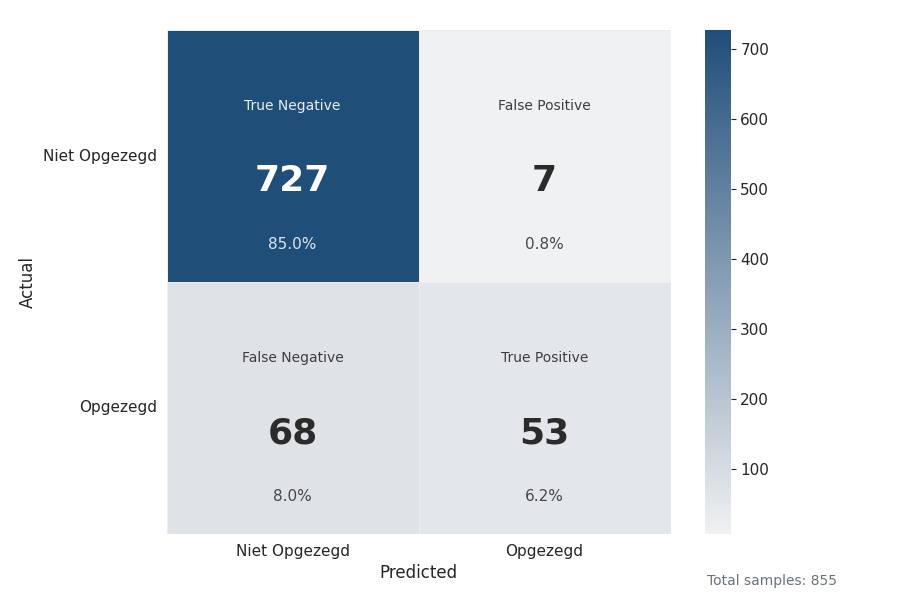

In [12]:
class_names = ["Niet Opgezegd", "Opgezegd"]

display_executive_model_evaluation(
    y,
    y_pred,
    class_names=class_names
)

In [13]:
def display_classification_report_boardroom(y_true, y_pred, class_names=None, max_width=900):

    unique_labels = sorted(list(set(y_true)))

    if class_names:
        if len(class_names) != len(unique_labels):
            raise ValueError("class_names moet dezelfde lengte hebben als unieke labels.")
        label_map = dict(zip(unique_labels, class_names))
        y_true = [label_map[y] for y in y_true]
        y_pred = [label_map[y] for y in y_pred]
        used_labels = class_names
    else:
        used_labels = [str(l) for l in unique_labels]

    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    macro = report.get("macro avg", {})
    weighted = report.get("weighted avg", {})

    class_metrics = []
    for cls in used_labels:
        c = report.get(cls, {"precision":0,"recall":0,"f1-score":0,"support":0})
        class_metrics.append({
            "label": cls,
            "precision": c["precision"],
            "recall": c["recall"],
            "f1": c["f1-score"],
            "support": int(c["support"])
        })

    hover = {
        "accuracy": "Percentage correcte voorspellingen = juiste voorspellingen / totaal aantal observaties.",
        "macro": "Macro gemiddelde: gelijke weging per klasse, ongeacht grootte.",
        "weighted": "Weighted gemiddelde: gewogen naar aantal observaties per klasse.",
        "precision": "Precision = TP / (TP + FP) → Hoeveel van de voorspelde positieven waren correct.",
        "recall": "Recall = TP / (TP + FN) → Hoeveel van de werkelijke positieven zijn gevonden.",
        "f1": "F1-score = Harmonic mean van Precision en Recall.",
        "support": "Aantal observaties in deze klasse."
    }

    def info_icon(text):
        return f'<span style="font-size:12px; color:#6B7280; cursor:help; margin-left:4px;" title="{text}">ⓘ</span>'

    # HTML layout adjustments to make the sections align similarly
    html = f"""
    <div style="
        font-family: 'Segoe UI', Arial, sans-serif;
        max-width:{max_width}px;
        padding:40px;
        background:white;
        color:#111827;
    ">

        <div style="font-size:26px; font-weight:600; margin-bottom:35px;">
            Model Performance Summary
        </div>

        <div style="display:flex; justify-content:space-between; margin-bottom:40px;">

            <div>
                <div style="font-size:13px; color:#6B7280;">
                    Accuracy {info_icon(hover["accuracy"])}
                </div>
                <div style="font-size:42px; font-weight:600; margin-top:4px;">
                    {acc:.2%}
                </div>
            </div>

            <div>
                <div style="font-size:13px; color:#6B7280;">
                    Macro Average {info_icon(hover["macro"])}
                </div>
                <div style="margin-top:6px; font-size:16px;">
                    Precision: <b>{macro.get("precision",0):.2f}</b><br>
                    Recall: <b>{macro.get("recall",0):.2f}</b><br>
                    F1-score: <b>{macro.get("f1-score",0):.2f}</b>
                </div>
            </div>

            <div>
                <div style="font-size:13px; color:#6B7280;">
                    Weighted Average {info_icon(hover["weighted"])}
                </div>
                <div style="margin-top:6px; font-size:16px;">
                    Precision: <b>{weighted.get("precision",0):.2f}</b><br>
                    Recall: <b>{weighted.get("recall",0):.2f}</b><br>
                    F1-score: <b>{weighted.get("f1-score",0):.2f}</b>
                </div>
            </div>

        </div>

        <div style="height:1px; background:#E5E7EB; margin-bottom:30px;"></div>

        <div style="font-size:18px; font-weight:600; margin-bottom:20px;">
            Per Class Performance
        </div>

        <table style="width:100%; border-collapse:collapse; font-size:15px;">
            <thead>
                <tr style="text-align:left; border-bottom:2px solid #111827;">
                    <th style="padding:10px 0;">Class</th>
                    <th>Precision {info_icon(hover["precision"])}</th>
                    <th>Recall {info_icon(hover["recall"])}</th>
                    <th>F1-score {info_icon(hover["f1"])}</th>
                    <th>Support {info_icon(hover["support"])}</th>
                </tr>
            </thead>
            <tbody>
    """

    for c in class_metrics:
        html += f"""
            <tr style="border-bottom:1px solid #E5E7EB;">
                <td style="padding:12px 0;">{c['label']}</td>
                <td>{c['precision']:.2f}</td>
                <td>{c['recall']:.2f}</td>
                <td>{c['f1']:.2f}</td>
                <td>{c['support']}</td>
            </tr>
        """

    html += """
            </tbody>
        </table>
    </div>
    """

    display(HTML(html))

# Example usage:
class_names = ["Niet Opgezegd", "Opgezegd"]
display_classification_report_boardroom(y, y_pred, class_names=class_names)


Class,Precision ⓘ,Recall ⓘ,F1-score ⓘ,Support ⓘ
Niet Opgezegd,0.91,0.99,0.95,734
Opgezegd,0.88,0.44,0.59,121


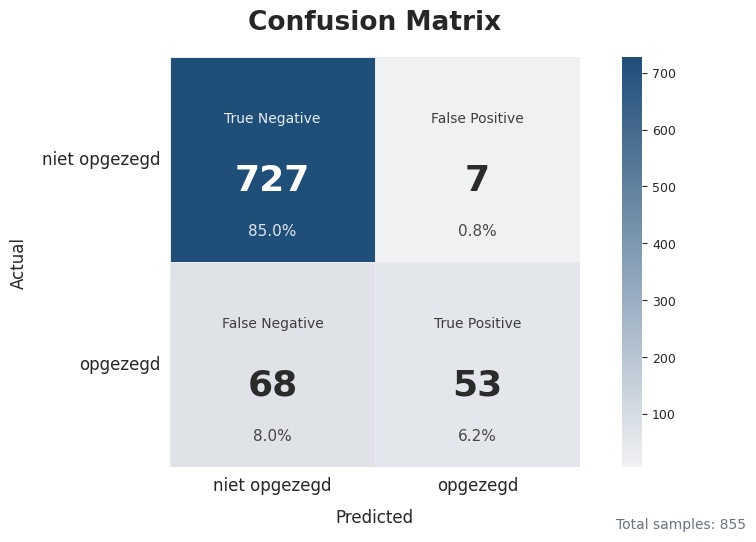

In [14]:
def plot_confusion_matrix(y_true, y_pred, classes=None, title="Confusion Matrix"):
    """
    Plot een nette corporate-stijl confusion matrix met counts, percentages, en TP/TN labels.

    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    classes : list, optional
        Namen van de classes (volgorde moet overeenkomen met unieke labels)
    title : str
        Titel boven de matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    percent = cm / total * 100
    
    # Default classnames
    if classes is None:
        classes = [str(i) for i in range(len(cm))]

    pos_labels = [["True Negative", "False Positive"],
                  ["False Negative", "True Positive"]]

    # Corporate stijl
    sns.set_style("white")
    plt.rcParams.update({"font.family": "DejaVu Sans", "font.size": 11})
    
    fig, ax = plt.subplots(figsize=(9, 5.5))
    
    cmap = sns.light_palette("#1f4e79", as_cmap=True)
    
    heatmap = sns.heatmap(
        cm,
        annot=False,
        cmap=cmap,
        cbar=True,
        linewidths=0.6,
        linecolor="#ECECEC",
        square=True,
        ax=ax
    )
    
    threshold = cm.max() / 2
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > threshold else "#2b2b2b"
            
            # TP/TN/FP/FN label boven
            ax.text(j + 0.5, i + 0.30,
                    pos_labels[i][j],
                    ha='center', va='center',
                    fontsize=10,
                    color=color,
                    alpha=0.9)
            
            # Groot getal in het midden
            ax.text(j + 0.5, i + 0.60,
                    f"{cm[i,j]:,}",
                    ha='center', va='center',
                    fontsize=26,
                    fontweight='bold',
                    color=color)
            
            # Percentage onderin
            ax.text(j + 0.5, i + 0.85,
                    f"{percent[i,j]:.1f}%",
                    ha='center', va='center',
                    fontsize=11,
                    color=color,
                    alpha=0.85)
    
    # Titel
    ax.set_title(title,
                 fontsize=19,
                 fontweight="semibold",
                 pad=20)
    
    # Totale samples rechtsonder
    fig.text(0.98, 0.02,
             f"Total samples: {total:,}",
             ha="right",
             va="bottom",
             fontsize=10,
             color="#6B7280")
    
    # As labels
    ax.set_xlabel("Predicted", fontsize=12, labelpad=10)
    ax.set_ylabel("Actual", fontsize=12, labelpad=10)
    
    ax.set_xticks(np.arange(len(classes)) + 0.5)
    ax.set_xticklabels(classes, fontsize=12)
    
    ax.set_yticks(np.arange(len(classes)) + 0.5)
    ax.set_yticklabels(classes, fontsize=12, rotation=0)
    
    # Colorbar styling
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=9)
    cbar.outline.set_visible(False)
    
    # Randen verwijderen
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    plt.tight_layout()
    plt.show()

classes = ["niet opgezegd", "opgezegd"]
plot_confusion_matrix(y, y_pred, classes)


Class,Precision,Recall,F1-score,Support
Niet Opgezegd,0.91,0.99,0.95,734
Opgezegd,0.88,0.44,0.59,121

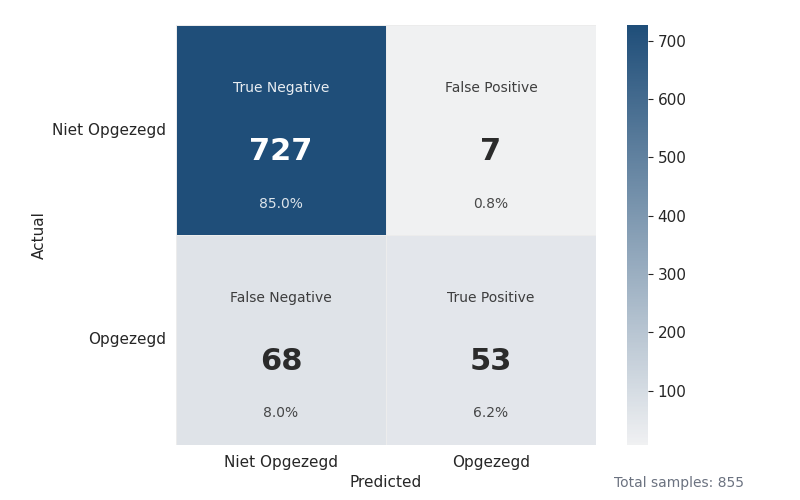

In [15]:

def display_executive_model_evaluation(y_true, y_pred, class_names=None):

    # -------------------------
    # Label mapping
    # -------------------------
    unique_labels = sorted(list(set(y_true)))

    if class_names:
        if len(class_names) != len(unique_labels):
            raise ValueError("class_names moet dezelfde lengte hebben als unieke labels.")
        label_map = dict(zip(unique_labels, class_names))
        y_true = [label_map[y] for y in y_true]
        y_pred = [label_map[y] for y in y_pred]
        used_labels = class_names
    else:
        used_labels = [str(l) for l in unique_labels]

    # -------------------------
    # Metrics
    # -------------------------
    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    macro = report.get("macro avg", {})
    weighted = report.get("weighted avg", {})

    class_metrics = []
    for cls in used_labels:
        c = report.get(cls, {"precision":0,"recall":0,"f1-score":0,"support":0})
        class_metrics.append({
            "label": cls,
            "precision": c["precision"],
            "recall": c["recall"],
            "f1": c["f1-score"],
            "support": int(c["support"])
        })

    # -------------------------
    # Hover explanations
    # -------------------------
    hover = {
        "accuracy": "Percentage correcte voorspellingen.",
        "macro": "Macro gemiddelde per klasse.",
        "weighted": "Weighted gemiddelde naar aantal observaties.",
        "precision": "Precision = TP / (TP + FP)",
        "recall": "Recall = TP / (TP + FN)",
        "f1": "F1-score = Harmonic mean van Precision en Recall.",
        "support": "Aantal observaties in deze klasse."
    }

    def info_icon(text):
        return f'<span style="font-size:10px; color:#9CA3AF; cursor:help; margin-left:4px;" title="{text}">ⓘ</span>'

    # -------------------------
    # HTML REPORT
    # -------------------------
    html = f"""
    <div style="
        font-family:'Segoe UI', Arial, sans-serif;
        max-width:850px;
        padding:40px;
        color:#111827;
        background:#FFFFFF;
        border-radius:8px;
        box-shadow: 0 8px 20px rgba(0,0,0,0.1);  
    ">

        <div style="font-size:22px; font-weight:600; margin-bottom:20px;">
            Model Performance
        </div>

        <div style="display:flex; justify-content:space-between; margin-bottom:30px;">

            <div>
                <div style="font-size:12px; color:#6B7280;">
                    Accuracy {info_icon(hover["accuracy"])}
                </div>
                <div style="font-size:36px; font-weight:600; margin-top:4px;">
                    {acc:.2%}
                </div>
            </div>

            <div>
                <div style="font-size:12px; color:#6B7280;">
                    Macro Average {info_icon(hover["macro"])}
                </div>
                <div style="margin-top:6px; font-size:14px;">
                    Precision: <b>{macro.get("precision",0):.2f}</b><br>
                    Recall: <b>{macro.get("recall",0):.2f}</b><br>
                    F1-score: <b>{macro.get("f1-score",0):.2f}</b>
                </div>
            </div>

            <div>
                <div style="font-size:12px; color:#6B7280;">
                    Weighted Average {info_icon(hover["weighted"])}
                </div>
                <div style="margin-top:6px; font-size:14px;">
                    Precision: <b>{weighted.get("precision",0):.2f}</b><br>
                    Recall: <b>{weighted.get("recall",0):.2f}</b><br>
                    F1-score: <b>{weighted.get("f1-score",0):.2f}</b>
                </div>
            </div>

        </div>

        <div style="height:1px; background:#E5E7EB; margin-bottom:25px;"></div>

        <div style="font-size:16px; font-weight:600; margin-bottom:12px;">
            Per Class Performance
        </div>

        <table style="width:100%; border-collapse:collapse; font-size:13px;">
            <thead>
                <tr style="text-align:left; border-bottom:2px solid #111827;">
                    <th style="padding:8px 0;">Class</th>
                    <th>Precision</th>
                    <th>Recall</th>
                    <th>F1-score</th>
                    <th>Support</th>
                </tr>
            </thead>
            <tbody>
    """

    for c in class_metrics:
        html += f"""
            <tr style="border-bottom:1px solid #E5E7EB;">
                <td style="padding:8px 0;">{c['label']}</td>
                <td><b>{c['precision']:.2f}</b></td>
                <td><b>{c['recall']:.2f}</b></td>
                <td><b>{c['f1']:.2f}</b></td>
                <td>{c['support']}</td>
            </tr>
        """

    html += """
            </tbody>
        </table>

        <div style="height:1px; background:#E5E7EB; margin:20px 0;"></div>

        <div style="font-size:16px; font-weight:600; margin-bottom:5px;">
            Confusion Matrix
        </div>

        <div id="confusion-matrix-container" style="display:flex; justify-content:center; width:100%; padding:0px 0;">
            <img src="data:image/png;base64,{confusion_matrix_img}" alt="Confusion Matrix" width="75%" />
        </div>

    </div>
    """

    # -------------------------
    # CONFUSION MATRIX
    # -------------------------
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    percent = cm / total * 100

    sns.set_style("white")
    plt.rcParams.update({"font.family": "DejaVu Sans"})

    fig, ax = plt.subplots(figsize=(8, 5))  # Verhoogde figuurafmetingen

    cmap = sns.light_palette("#1f4e79", as_cmap=True)

    heatmap = sns.heatmap(
        cm,
        annot=False,
        cmap=cmap,
        cbar=True,
        linewidths=0.6,
        linecolor="#ECECEC",
        square=True,
        ax=ax
    )

    threshold = cm.max() / 2

    labels_matrix = [["True Negative", "False Positive"],
                    ["False Negative", "True Positive"]]

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > threshold else "#2b2b2b"

            ax.text(j + 0.5, i + 0.30,
                    labels_matrix[i][j],
                    ha='center', va='center',
                    fontsize=10,  # Kleinere lettertype
                    color=color,
                    alpha=0.9)
            
            # Groot getal in het midden
            ax.text(j + 0.5, i + 0.60,
                    f"{cm[i,j]:,}",
                    ha='center', va='center',
                    fontsize=22,  # Vergrote cijfers
                    fontweight='bold',
                    color=color)
            
            # Percentage onderin
            ax.text(j + 0.5, i + 0.85,
                    f"{percent[i,j]:.1f}%",
                    ha='center', va='center',
                    fontsize=10,  # Kleinere tekst
                    color=color,
                    alpha=0.85)

    fig.text(0.93, 0.02,
            f"Total samples: {total:,}",
            ha="right",
            va="bottom",
            fontsize=10,
            color="#6B7280")

    fig.subplots_adjust(top=0.95)

    ax.set_xlabel("Predicted", fontsize=11)
    ax.set_ylabel("Actual", fontsize=11)

    ax.set_xticklabels(used_labels)
    ax.set_yticklabels(used_labels, rotation=0)

    for spine in ax.spines.values():
        spine.set_visible(False)

    # Sla de plot op in geheugen
    img_buffer = BytesIO()
    plt.savefig(img_buffer, format='png')
    img_buffer.seek(0)

    # Zet het om naar base64
    confusion_matrix_img = base64.b64encode(img_buffer.read()).decode('utf-8')

    # Pas de HTML aan
    html = html.format(confusion_matrix_img=confusion_matrix_img)

    plt.close()

    # Display de volledige HTML
    display(HTML(html))

# Usage example:
class_names = ["Niet Opgezegd", "Opgezegd"]

display_executive_model_evaluation(
    y,
    y_pred,
    class_names=class_names
)
